# Predicting Stock Prices for a Portfolio

In this notebook we will predict the stock prices of a portfolio using Linear Regression.

## Data and Inputs:

The data will use the following stocks in the portfolio:

- Apple
- Amazon
- Exelon Corporation 
- Nasdaq
- Royal Gold Inc.
<br>

**Training and Testing Data Period:** <br>
Start Date: July 1, 2015 <br>
End Date: Dec 31, 2018

# Set up the notebook
We will begin by importing all the necessary Python modules required to run the notebook.

In [261]:
%matplotlib inline

import quandl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from dateutil.parser import parse
from sklearn import metrics

# Load and Explore the Data
We will trading data, collected over the time period of:

**Start Date:** July 1, 2015 <br> 
**End Date:** Dec 31, 2018    
    
The cell below will download this data from the quandl API, giving you data in the form of a pandas dataframe.

In [262]:
start_date = "2015-7-1"
end_date = "2017-12-31"

In [263]:
dfAAPL = quandl.get("WIKI/AAPL", start_date="2015-7-1", end_date="2017-12-31")
dfAAPL = dfAAPL.rename(columns={'Adj. Close':'AAPL'})

dfAMZN = quandl.get("WIKI/AMZN", start_date="2015-7-1", end_date="2017-12-31")
dfAMZN = dfAMZN.rename(columns={'Adj. Close':'AMZN'})

dfEXC = quandl.get("WIKI/EXC", start_date="2015-7-1", end_date="2017-12-31")
dfEXC = dfEXC.rename(columns={'Adj. Close':'EXC'})

dfNDAQ = quandl.get("WIKI/NDAQ", start_date="2015-7-1", end_date="2017-12-31")
dfNDAQ = dfNDAQ.rename(columns={'Adj. Close':'NDAQ'})

dfRGLD = quandl.get("WIKI/RGLD", start_date="2015-7-1", end_date="2017-12-31")
dfRGLD = dfRGLD.rename(columns={'Adj. Close':'RGLD'})


# Pre-Process the Data

The /quandl dataframes have the following attributes:
* Date
* Open
* High
* Low
* Close
* Volume
* Ex-Dividend
* Split Ratio
* Adj. Open
* Adj. High
* Adj. Low
* Adj. Close
* Adj. Volume

Of all these columns, we will use only ***Adj. Close***. This is because the trading data is very volatile and 
changes several times within a day. Adjusted closing price factors a stock's value to reflect any corporate 
actions such as dividends, rights offerings and stock splits. For more information, [visit this post.](https://www.investopedia.com/terms/a/adjusted_closing_price.asp#:~:text=The%20adjusted%20closing%20price%20amends,detailed%20analysis%20of%20past%20performance.)

This is the reason why you will notice that each of the stock's adjusted price has been renamed to its ticker symbol in the cell above.

**Below, we will create a new DataFrame and join the portfolio value from the individual DataFrames above.**

In [264]:
start_date="2015-07-1"
end_date="2017-12-31"

Date = pd.date_range(start_date, end_date)

df=pd.DataFrame(index=Date)

df = pd.concat([dfAAPL, dfAMZN, dfEXC, dfNDAQ, dfRGLD], axis=1)
df = df.dropna()
df = df[['AAPL', 'AMZN', 'EXC', 'NDAQ', 'RGLD']]

df

,AAPL,AMZN,EXC,NDAQ,RGLD
Date,,,,,
2015-07-01,121.243068,437.39,29.107162,46.691199,58.987619
2015-07-02,121.089838,437.71,29.400710,47.093792,60.214716
2015-07-06,120.668456,436.04,29.299803,46.739127,61.282387
2015-07-07,120.371574,436.72,30.061194,46.815812,59.548025
2015-07-08,117.383593,429.70,29.905246,45.876428,59.678465
...,...,...,...,...,...
2017-12-22,175.010000,1168.36,39.010000,76.090000,86.560000
2017-12-26,170.570000,1176.76,38.810000,76.130000,87.650000
2017-12-27,170.600000,1182.26,38.990000,76.340000,86.730000


# Visualize the Data

We will now plot the data from the DataFrame that we created to visualize the progress.

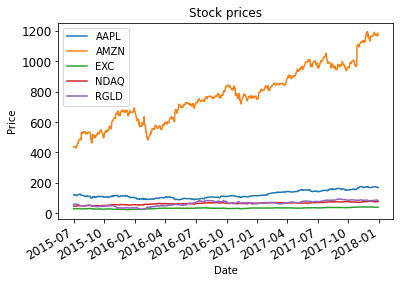

In [265]:
def plot_data(df, title="Stock prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()
    
plot_data(df)

# Normalize the Data

Since the stocks trade at significantly different prices, it is hard to make a fair comparison. We will make them all 
begin at one fair point so that the comparison is on an equal footing. We will achieve this using data normalization. We will normalize price data, so that each value begins at 1.

In [266]:
def normalize_data(df):
    df = df/df.iloc[0, :]
    return df
df = normalize_data(df)
df.head()

,AAPL,AMZN,EXC,NDAQ,RGLD
Date,,,,,
2015-07-01,1.000000,1.000000,1.000000,1.000000,1.000000
2015-07-02,0.998736,1.000732,1.010085,1.008622,1.020803
2015-07-06,0.995261,0.996914,1.006618,1.001026,1.038903
2015-07-07,0.992812,0.998468,1.032777,1.002669,1.009500
2015-07-08,0.968167,0.982418,1.027419,0.982550,1.011712


# Plot Normalized Data

On plotting this normalized data, we will find that the stocks movement is relatively closer together. Hence we can
make a fair comparison.

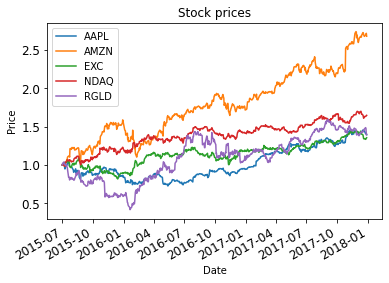

In [267]:
plot_data(df)

In [268]:
%%html
<style>
table {float:left}
</style>

# Create a Portfolio

We will now use an investment value and assign weights to each stock in the portfolio.

Assuming the ***investment value is $10,000*** and we assign weightages in the following order:

Stock | Weights
:--- | :---
Apple|25%
Amazon|25%
Exelon Corporation| 10%
Nasdaq| 30%
Royal Gold Inc.| 10%

The cell below returns allocated weights for each stock price.

In [269]:
weight = {'AAPL':0.25, 'AMZN': 0.25, 'EXC': 0.1,'NDAQ': 0.3, 'RGLD': 0.1}

def allocated_df():
    df['AAPL']=df['AAPL']*weight['AAPL']
    df['AMZN']=df['AMZN']*weight['AMZN']
    df['EXC']=df['EXC']*weight['EXC']
    df['NDAQ']=df['NDAQ']*weight['NDAQ']
    df['RGLD']=df['RGLD']*weight['RGLD']
    return df

allocated_df().head()

,AAPL,AMZN,EXC,NDAQ,RGLD
Date,,,,,
2015-07-01,0.250000,0.250000,0.100000,0.300000,0.100000
2015-07-02,0.249684,0.250183,0.101009,0.302587,0.102080
2015-07-06,0.248815,0.249228,0.100662,0.300308,0.103890
2015-07-07,0.248203,0.249617,0.103278,0.300801,0.100950
2015-07-08,0.242042,0.245605,0.102742,0.294765,0.101171


# Assign the Investment Amount

The cell below assigns the investment amount with the weightage for each stock. We now get an extra column called ***Portfolio Val***
which indicates the day/'s gain or loss for the entire invested amount.

In [270]:
investment_value=10000
portfolio = ['AAPL', 'AMZN', 'EXC', 'NDAQ', 'RGLD']
df = df*investment_value
df["Portfolio Val"] = df[portfolio].sum(axis=1)
df

,AAPL,AMZN,EXC,NDAQ,RGLD,Portfolio Val
Date,,,,,,
2015-07-01,2500.000000,2500.000000,1000.000000,3000.000000,1000.000000,10000.000000
2015-07-02,2496.840442,2501.829031,1010.085093,3025.867378,1020.802621,10055.424566
2015-07-06,2488.151659,2492.283774,1006.618342,3003.079450,1038.902539,10029.035764
2015-07-07,2482.030016,2496.170466,1032.776552,3008.006569,1009.500410,10028.484013
2015-07-08,2420.418641,2456.046092,1027.418847,2947.649353,1011.711712,9863.244645
...,...,...,...,...,...,...
2017-12-22,3608.659917,6678.021903,1340.219995,4888.929875,1467.426587,17983.258276
2017-12-26,3517.108291,6726.033974,1333.348834,4891.499952,1485.905041,17953.896092
2017-12-27,3517.726883,6757.470450,1339.532879,4904.992859,1470.308547,17990.031618


##### Tabulate the summary of the data.

In [271]:
df.describe()

,AAPL,AMZN,EXC,NDAQ,RGLD,Portfolio Val
count,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,2535.721572,4451.436411,1138.981482,4148.425086,1099.031372,13373.595923
std,507.187034,1065.309928,141.148745,517.074148,289.779223,2352.693243
min,1820.478525,2456.046092,818.741340,2947.649353,419.438576,9500.286457
25%,2166.288949,3577.470907,1038.655613,3852.466429,842.419570,11281.620234
50%,2345.850303,4382.644779,1145.657948,4243.404754,1146.820239,13302.268737
75%,2979.011651,5420.962985,1219.646102,4485.868853,1342.920516,15365.576956
max,3637.733744,6835.032808,1456.342620,5093.251034,1593.197851,18309.025416


# Write the Data to a CSV File

We will now write this data to a csv file titled *portfolio.csv*.

In [272]:
df.to_csv('portfolio.csv', sep='\t', encoding='utf-8')

# Capital Asset Pricing Model: Regression Analysis


## ${r}_{p}(t) = {\beta}_{p}{r}_{m}(t) + {\alpha}_{p}(t) $

In formal financial language, the regression model is the same as the Capital Asset Pricing Model (CAPM) equation where: <br />

${r}_{p}(t)$: Return on portfolio for a given day *t* <br />
${\beta}_{p}$: Co-efficient <br />
${r}_{m}$: Market returns; viz S&P 500 values <br />
${\alpha}_{p}(t)$: Intercept <br />

The CAPM emphasizes that the return on any stock or portfolio is due to the markets. This is why ${r}_{m}(t)$ is the independent x-variable in this equation. Since we are predicting the returns on the portfolio value, it is the dependent y-variable in this equation, represented by ${r}_{p}(t)$.

# Create a New Dataframe for the Model's X & Y Variables

### Column 1: Portfolio Values

We will now create a new dataframe that will contain all the X and Y variables that will be used in out predictive models. The cell below will add the dependent variable column 'Portfolio Val' which values are to be predicted. 

In [273]:
dfX = pd.read_csv("portfolio.csv", sep='\t')
dfX.set_index('Date')

dfX = dfX[['Portfolio Val']]
dfX['Portfolio Val'] = dfX['Portfolio Val'].astype(float)
dfX

,Portfolio Val
0,10000.000000
1,10055.424566
2,10029.035764
3,10028.484013
4,9863.244645
...,...
624,17983.258276
625,17953.896092
626,17990.031618
627,17974.392222


### Column 2: S&P 500 Values
Next, we will read the S&P500 values from the attached csv file 'S&P500.csv' and add it as our second column.

In [274]:
data = pd.read_csv("S&P500.csv")
data['Date']  # as a Series
date_array = data['Date'].values  # as a numpy array
d_list = []
for date in date_array:
    dt = parse(date)
    d_item = (str(dt.date()))    
    d_list.append(d_item)
dfDate = pd.DataFrame(d_list,columns=['Date'])
dfDate.set_index('Date')
dfSP500 = pd.read_csv("S&P500.csv")
dfSP500.set_index('Date')
dfSP500 = dfSP500.rename(columns={'Price':'SP500', 'Date':'ODate'})

for i, col in enumerate(dfSP500.columns):
    dfSP500.iloc[:, i] = dfSP500.iloc[:, i].str.replace(',', '')
    
dfSP500 = dfSP500.join(dfDate)
dfSP500 = dfSP500.dropna()
dfSP500 = dfSP500[['SP500']]
dfSP500['SP500'] = dfSP500['SP500'].astype(float)
dfSP500 = dfSP500[::-1]
dfSP500.reset_index(inplace=True, drop=True)

In [275]:
dfX = dfX.join(dfSP500, lsuffix='SP500')
dfX.dropna()

,Portfolio Val,SP500
0,10000.000000,2077.42
1,10055.424566,2076.78
2,10029.035764,2068.76
3,10028.484013,2081.34
4,9863.244645,2046.68
...,...,...
624,17983.258276,2679.25
625,17953.896092,2684.57
626,17990.031618,2683.34
627,17974.392222,2680.50


#### Append the Column Containing Market Return Values to the Variable Dataframe

### Column 3: Rolling mean of portfolio values
We will use a 5-day rolling mean for the values of 5 consecutive days on a rolling basis.

$$ Rolling Mean = \frac{Portfolio Value(t)}{Mean(n:t)}$$

In [276]:
rolling_duration = 5
dfX['Rolling_mean_PV'] = dfX['Portfolio Val'].rolling(rolling_duration).mean()

### Column 4: Rolling standard deviation of portfolio values

We will use a 5-day rolling standard deviation for the values of 5 consecutive days on a rolling basis.

$$ Rolling Standard Deviation = \frac{Portfolio Value(t)}{Standard Deviation(n:t)}$$

In [277]:
dfX['Rolling_std_PV'] = dfX['Portfolio Val'].rolling(rolling_duration).std()

### Column 5: Upper Bollinger band 
We will use the upper bollinger band which is the sum of the 5-day rolling mean and 2x of the 5-day rolling standard deviation.

$$ Upper Band = Rolling Mean + 2* Rolling Standard Deviation $$

In [278]:
dfX['upper_band_PV'] = dfX['Rolling_mean_PV']+ (2*dfX['Rolling_std_PV'])

### Column 6: Lower Bollinger band 
We will use the lower bollinger band which is the difference of the 5-day rolling mean and 2x of the 5-day rolling standard deviation.

$$ Lower Band = Rolling Mean - 2* Rolling Standard Deviation $$

In [279]:
dfX['lower_band_PV'] = dfX['Rolling_mean_PV']- (2*dfX['Rolling_std_PV'])

### Column 7: Bollinger bands
We will get bollinger bands which is 2x of the 5-day rolling standard deviation.

$$ Bollinger Bands = \frac{Portfolio Value(t) - Rolling Average (n:t)}{2 * Rolling Standard Deviation (t)}$$

<br><br>
    <i> where, <br>
Portfolio Value(t) = Portfolio value on a given day **t**  <br>
       Mean(n:t) = Mean of portfolio values during a window of **n** days upto **t** day  <br>
       Standard Deviation(n:t) = Standard Deviation of portfolio values during a window of **n** days upto **t** day
        </i>

In [280]:
dfX['BB'] = (dfX['Portfolio Val']- dfX['Rolling_mean_PV'])/(2*dfX['Rolling_std_PV'])
dfX.fillna(dfX.mean())

,Portfolio Val,SP500,Rolling_mean_PV,Rolling_std_PV,upper_band_PV,lower_band_PV,BB
0,10000.000000,2077.42,13369.735506,104.566367,13578.868239,13160.602773,0.107968
1,10055.424566,2076.78,13369.735506,104.566367,13578.868239,13160.602773,0.107968
2,10029.035764,2068.76,13369.735506,104.566367,13578.868239,13160.602773,0.107968
3,10028.484013,2081.34,13369.735506,104.566367,13578.868239,13160.602773,0.107968
4,9863.244645,2046.68,9995.237797,76.346138,10147.930074,9842.545520,-0.864439
...,...,...,...,...,...,...,...
624,17983.258276,2679.25,18034.986713,109.541511,18254.069735,17815.903691,-0.236113
625,17953.896092,2684.57,17983.406597,50.021882,18083.450361,17883.362832,-0.294976
626,17990.031618,2683.34,17967.594727,19.109936,18005.814600,17929.374854,0.587048
627,17974.392222,2680.50,17973.523356,14.224080,18001.971516,17945.075196,0.030542


### A Summary of the Dataframe of Variables

In [281]:
dfX.describe()

,Portfolio Val,SP500,Rolling_mean_PV,Rolling_std_PV,upper_band_PV,lower_band_PV,BB
count,629.000000,629.000000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,13373.595923,2223.049141,13369.735506,104.566367,13578.868239,13160.602773,0.107968
std,2352.693243,207.102255,2335.808491,65.500885,2324.243397,2354.616353,0.503634
min,9500.286457,1829.080000,9839.985634,5.041378,10144.953111,9048.230215,-0.887889
25%,11281.620234,2071.180000,11271.397308,61.324932,11466.753995,11091.556441,-0.302416
50%,13302.268737,2168.270000,13303.927717,90.126445,13519.850888,13092.697880,0.202620
75%,15365.576956,2396.920000,15363.311964,135.399861,15604.631598,15041.415126,0.546905
max,18309.025416,2690.160000,18207.281931,528.000548,18504.266930,18027.006482,0.894274


In [282]:
X_head = dfX.iloc[:, dfX.columns != 'Portfolio Val']

Write the data into a .csv file called 'XY_var.csv'

In [283]:
dfX[rolling_duration-1:].to_csv('XY_var.csv', sep='\t', encoding='utf-8')

In [284]:
y = pd.read_csv("XY_var.csv", sep='\t')
y = y['Portfolio Val'].to_numpy()
y.shape

(625,)

In [285]:
x = pd.read_csv("XY_var.csv", sep='\t')
x = x[['SP500', 'Rolling_mean_PV', 'Rolling_std_PV', 'upper_band_PV', 'lower_band_PV', 'BB']]
x = x.to_numpy()
x.shape

(625, 6)

### Prepare and Split the Data
Let us now we split the rows in the dataset up into train and test sets using the code below. 

In [286]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

### Decision Tree Model

We will create a Decision Tree model using Scikit-learn. Next, we will evaluate the accuracy by using the score function. We will use this to enable a model for predicting the stock price value by learning the rules of decisions 
derived from the data.

In [287]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor().fit(x_train, y_train)
regressor.score(x_train, y_train), regressor.score(x_test, y_test)

(1.0, 0.997878347909761)

#### Feature Importance of Independent Variables
We will guage the importance of each of the x variables used in the DecisionTreeRegressor class. We will use the 
feature_importances_ property to get the importance scores for the features used in the input. 

The results suggest that 2 out of 6 variables are of relative importance. Next, we will plot a bar chart to visualize the same. 

In [288]:
importance = regressor.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(X_head.columns[i], ':', v)

SP500 : 0.0006735943188128613
Rolling_mean_PV : 0.22689630024575835
Rolling_std_PV : 0.00012982130818200963
upper_band_PV : 0.7610221994661466
lower_band_PV : 0.010009647037572211
BB : 0.0012684376235279102


<AxesSubplot:>

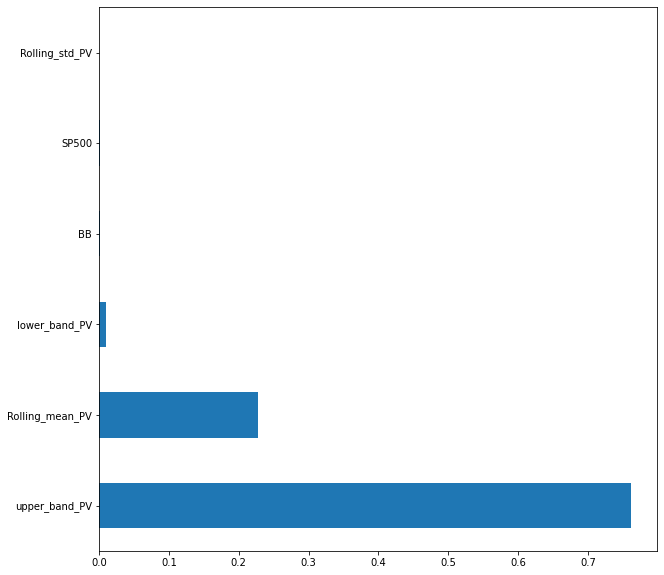

In [289]:
feat_importances = pd.Series(regressor.feature_importances_, index=X_head.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

##### We will compare the predicted values y_pred with the actual output values y_test and plot them in a table. In order to compare the predicted values y_pred with the actual output values y_test we will execute this script:

In [290]:
y_pred = regressor.predict(x_test)

In [291]:
dfYt = pd.DataFrame(y_test, columns=['y_test'])
dfYp = pd.DataFrame(y_pred, columns=['y_pred'])
dfYt = dfYt.join(dfYp)
dfYt['difference']=dfYt['y_test']-dfYt['y_pred']
dfYt = dfYt[['y_test', 'y_pred', 'difference']]
dfYt

,y_test,y_pred,difference
0,15618.487867,15618.006799,0.481068
1,14896.203893,14923.104018,-26.900125
2,16292.208540,16353.551123,-61.342583
3,15261.746864,15365.576956,-103.830091
4,10705.228181,10677.029831,28.198350
...,...,...,...
120,10228.591291,10238.354460,-9.763169
121,12977.103005,12995.679791,-18.576786
122,10220.186922,10119.242847,100.944075
123,15515.917854,15694.102590,-178.184736


##### Visualize the comparison using matplotlib:

<AxesSubplot:title={'center':'Actual Vs Predicted'}>

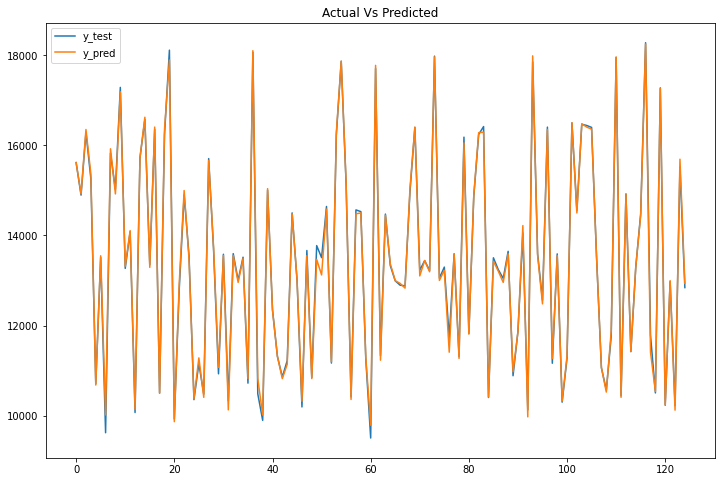

In [292]:
%matplotlib inline
dfYt = dfYt [['y_test', 'y_pred']]
dfYt.plot(title='Actual Vs Predicted', style=['-', '-'], figsize=(12,8))

We will evaluate the accuracy of the model using three commonly used methods:
1. Mean Absolute Error : It is the mean of the absolute value of the errors.
2. Mean Squared Error: It is the sum of the mean of the squared errors.
3. Root Mean Squared Error: It is the square-root of the sum of the mean of the squared errors.

In [293]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 72.34442825175127
Mean Squared Error: 11751.458504747217
Root Mean Squared Error: 108.4041443153684


**RMSE is 131.53. The 10% of mean portfolio value is: 1337.36. Since RMSE is lower that 10%
of the mean portfolio value, we can conclude that this model did a fairly good job of predicting
values.**

### Gradient Boosting Regressor

We will create a Gradient Boosting Regressor model using Scikit-learn. Next, we will evaluate the accuracy by using the score function. Gradient Boosting is used to get a predictive model using an ensemble of relatively weaker predictive models.

In [294]:
model = GradientBoostingRegressor(random_state=0).fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9998678173167533, 0.9985472125032997)

#### Feature Importance of Independent Variables
We will guage the importance of each of the x variables used in the GradientBoostingRegressor class. We will use the 
feature_importances_ property to get the importance scores for the features used in the input. 

The results suggest that 4 out of 6 variables are of relative importance. Next, we will plot a bar chart to visualize the same. 

In [295]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(X_head.columns[i], ':', v)

SP500 : 0.1579961854242738
Rolling_mean_PV : 0.3765182172201925
Rolling_std_PV : 0.00016107226256443754
upper_band_PV : 0.4387701436536028
lower_band_PV : 0.02528940759103104
BB : 0.00126497384833529


<AxesSubplot:>

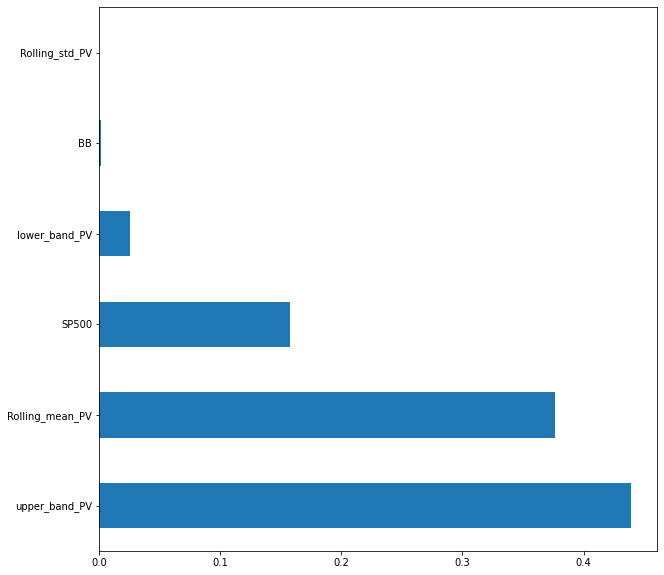

In [296]:
feat_importances = pd.Series(model.feature_importances_, index=X_head.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

##### We will compare the predicted values y_pred with the actual output values y_test and plot them in a table. In order to compare the predicted values y_pred with the actual output values y_test we will execute this script:

In [297]:
y_pred=model.predict(x_test)

#### To compare the predicted values y_pred with the actual output values y_test we will execute this script:

In [298]:
dfYt = pd.DataFrame(y_test, columns=['y_test'])
dfYp = pd.DataFrame(y_pred, columns=['y_pred'])
dfYt = dfYt.join(dfYp)
dfYt['difference']=dfYt['y_test']-dfYt['y_pred']
dfYt = dfYt[['y_test', 'y_pred', 'difference']]
dfYt

,y_test,y_pred,difference
0,15618.487867,15612.551247,5.936620
1,14896.203893,14906.662555,-10.458662
2,16292.208540,16336.860664,-44.652124
3,15261.746864,15347.154033,-85.407169
4,10705.228181,10672.233066,32.995115
...,...,...,...
120,10228.591291,10179.488375,49.102916
121,12977.103005,12993.022065,-15.919060
122,10220.186922,10150.394601,69.792321
123,15515.917854,15624.430305,-108.512452


##### Visualize the comparison using matplotlib.

<AxesSubplot:title={'center':'Actual Vs Predicted'}>

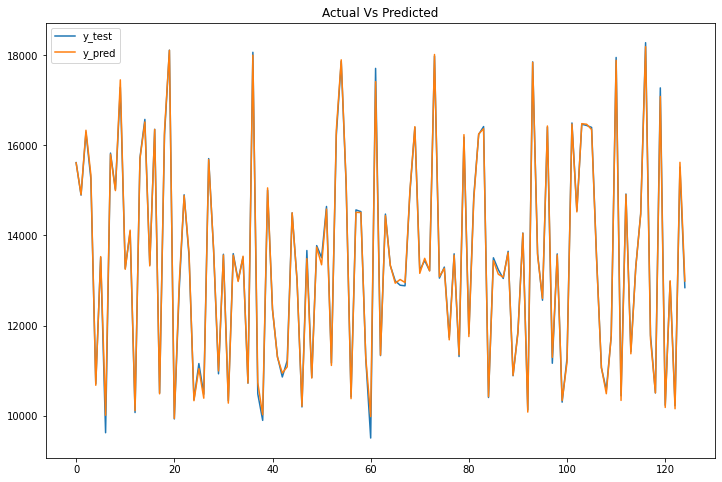

In [300]:
%matplotlib inline
dfYt = dfYt [['y_test', 'y_pred']]
dfYt.plot(title='Actual Vs Predicted', style=['-', '-'], figsize=(12,8))

We will evaluate the accuracy of the model using three commonly used methods:
1. Mean Absolute Error : It is the mean of the absolute value of the errors.
2. Mean Squared Error: It is the sum of the mean of the squared errors.
3. Root Mean Squared Error: It is the square-root of the sum of the mean of the squared errors.

In [301]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 57.14285478961184
Mean Squared Error: 8046.73492993216
Root Mean Squared Error: 89.70359485512361


**RMSE is 80.14. The 10% of mean portfolio value is: 1337.36. Since RMSE is lower that 10%
of the mean portfolio value, we can conclude that this model did a fairly good job of predicting
values.**

### Random Forest Regressor:

We will create a Random Forest Regressor model using Scikit-learn. Next, we will evaluate the accuracy by using the score function. It is a supervised learning model that uses ensemble regression learning. A Random Forest works by building several decision trees while training and resulting in the mean of all the classes for the prediction of all the decision trees.

In [302]:
model = RandomForestRegressor(random_state=0).fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9998116326114512, 0.9977983687350885)

#### Feature Importance of Independent Variables
We will guage the importance of each of the x variables used in the RandomForestRegressor class. We will use the 
feature_importances_ property to get the importance scores for the features used in the input. 

The results suggest that 4 out of 6 variables are of relative importance. Next, we will plot a bar chart to visualize the same. 

In [303]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(X_head.columns[i], ':', v)

SP500 : 0.15348272179214484
Rolling_mean_PV : 0.28764912650160457
Rolling_std_PV : 0.00024029568367875013
upper_band_PV : 0.5125945558941888
lower_band_PV : 0.045016439131914575
BB : 0.0010168609964684998


<AxesSubplot:>

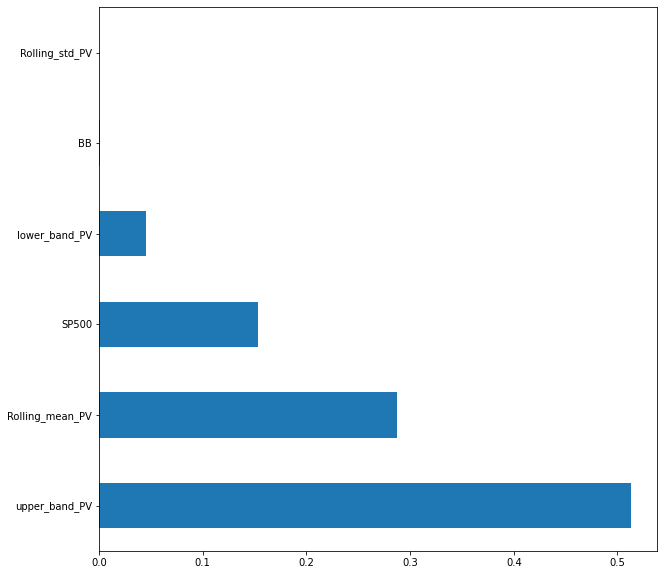

In [304]:
feat_importances = pd.Series(model.feature_importances_, index=X_head.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

##### We will compare the predicted values y_pred with the actual output values y_test and plot them in a table. In order to compare the predicted values y_pred with the actual output values y_test we will execute this script:

In [305]:
y_pred=model.predict(x_test)

#### To compare the predicted values y_pred with the actual output values y_test we will execute this script:

In [306]:
dfYt = pd.DataFrame(y_test, columns=['y_test'])
dfYp = pd.DataFrame(y_pred, columns=['y_pred'])
dfYt = dfYt.join(dfYp)
dfYt['difference']=dfYt['y_test']-dfYt['y_pred']
dfYt = dfYt[['y_test', 'y_pred', 'difference']]
dfYt

,y_test,y_pred,difference
0,15618.487867,15629.201037,-10.713170
1,14896.203893,14915.724844,-19.520951
2,16292.208540,16314.568286,-22.359746
3,15261.746864,15427.804661,-166.057796
4,10705.228181,10650.228211,54.999970
...,...,...,...
120,10228.591291,10198.174813,30.416477
121,12977.103005,12968.951082,8.151924
122,10220.186922,10118.709029,101.477894
123,15515.917854,15687.771474,-171.853620


##### Visualize this comparison using matplotlib.

<AxesSubplot:title={'center':'Actual Vs Predicted'}>

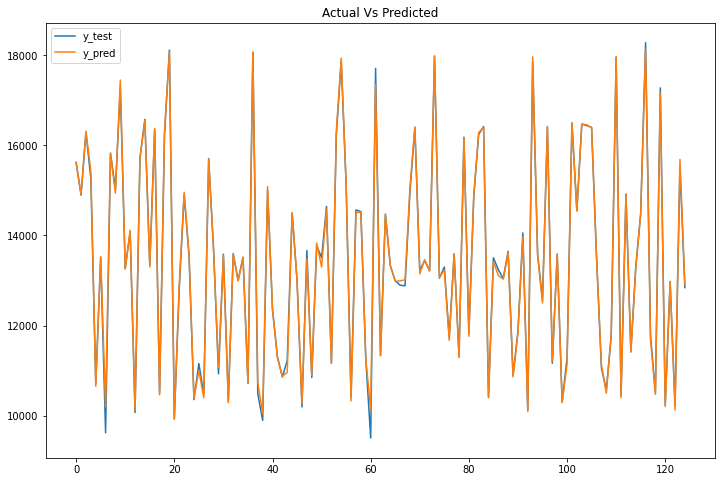

In [307]:
%matplotlib inline
dfYt = dfYt [['y_test', 'y_pred']]
dfYt.plot(title='Actual Vs Predicted', style=['-', '-'], figsize=(12,8))

We will evaluate the accuracy of the model using three commonly used methods:
1. Mean Absolute Error : It is the mean of the absolute value of the errors.
2. Mean Squared Error: It is the sum of the mean of the squared errors.
3. Root Mean Squared Error: It is the square-root of the sum of the mean of the squared errors.

In [308]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 63.25899263875747
Mean Squared Error: 12194.449114156228
Root Mean Squared Error: 110.42847963345429


**RMSE is 80.14. The 10% of mean portfolio value is: 1337.36. Since RMSE is lower that 10%
of the mean portfolio value, we can conclude that this model did a fairly good job of predicting
values.**